In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.head(50)


,image,label
0,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
1,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
2,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
3,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
4,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
5,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
6,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
7,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
8,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
9,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight


In [4]:
data.shape

(70295, 2)

In [5]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 56236 validated image filenames belonging to 38 classes.
Found 7029 validated image filenames belonging to 38 classes.
Found 7030 validated image filenames belonging to 38 classes.


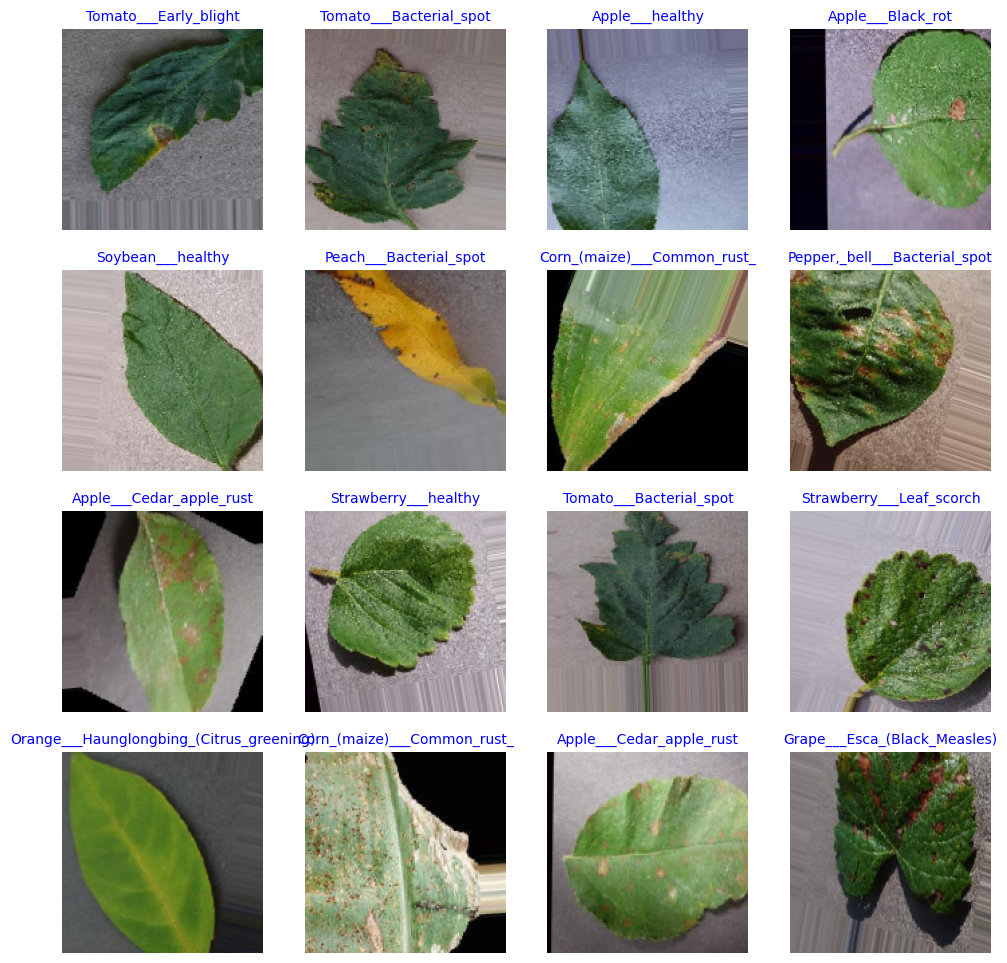

In [7]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")
            self.model.stop_training = True

In [9]:
from tensorflow.keras.layers import BatchNormalization


n_classes = 38
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))



model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,6

 Total params: 1,050,374 (4.01 MB)

 Trainable params: 1,048,902 (4.00 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/10
Epoch 1: Training accuracy is 0.4672
Epoch 1: Validation accuracy is 0.6598
1758/1758 - 344s - 196ms/step - accuracy: 0.4672 - loss: 2.8337 - val_accuracy: 0.6598 - val_loss: 1.7945 - learning_rate: 9.0484e-04
Epoch 2/10
Epoch 2: Training accuracy is 0.7695
Epoch 2: Validation accuracy is 0.7581
1758/1758 - 334s - 190ms/step - accuracy: 0.7695 - loss: 1.2659 - val_accuracy: 0.7581 - val_loss: 1.2055 - learning_rate: 8.1873e-04
Epoch 3/10
Epoch 3: Training accuracy is 0.8505
Epoch 3: Validation accuracy is 0.8096
1758/1758 - 330s - 188ms/step - accuracy: 0.8505 - loss: 0.8647 - val_accuracy: 0.8096 - val_loss: 0.9474 - learning_rate: 7.4082e-04
Epoch 4/10
Epoch 4: Training accuracy is 0.8827
Epoch 4: Validation accuracy is 0.8811
1758/1758 - 330s - 188ms/step - accuracy: 0.8827 - loss: 0.6978 - val_accuracy: 0.8811 - val_loss: 0.6813 - learning_rate: 6.7032e-04
Epoch 5/10
Epoch 5: Training accuracy is 0.9027
Epoch 5: Validation accuracy is 0.8270
1758/1758 - 331s - 188ms/step

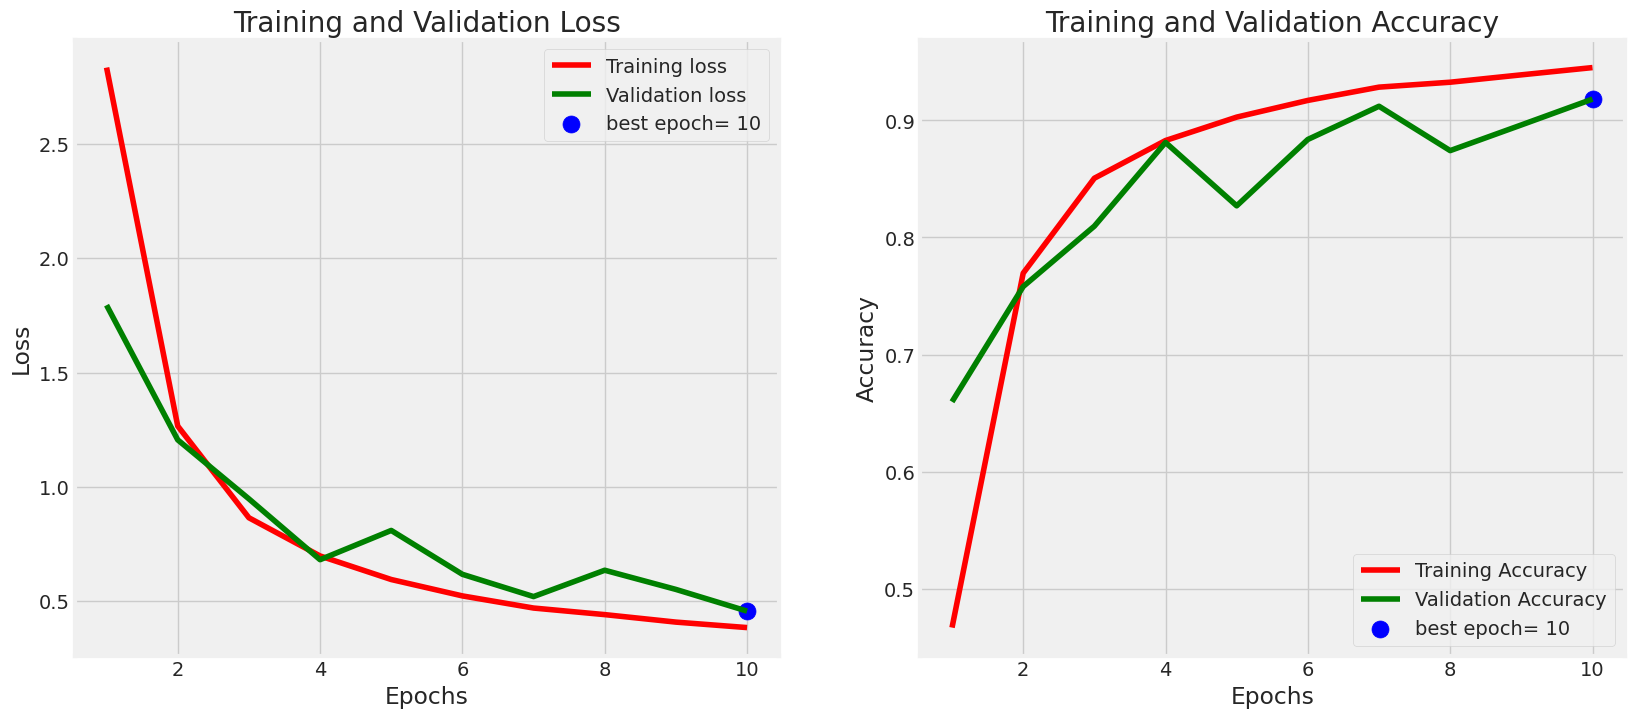

In [13]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()

In [14]:
model.save('model_914.h5')


In [15]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9161 - loss: 0.4637
Accuracy score: 0.9180538058280945


In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9580 - loss: 0.3604
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9152 - loss: 0.4684
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - accuracy: 0.9159 - loss: 0.4657
Train Loss:  0.35798805952072144
Train Accuracy:  0.9572368264198303
--------------------
Valid Loss:  0.466198205947876
Valid Accuracy:  0.91414475440979
--------------------
Test Loss:  0.45255017280578613
Test Accuracy:  0.9197368621826172


In [17]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step


In [18]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.96      0.97       202
                                 Apple___Black_rot       0.90      0.99      0.94       199
                          Apple___Cedar_apple_rust       1.00      0.99      0.99       176
                                   Apple___healthy       0.84      0.93      0.88       201
                               Blueberry___healthy       0.98      0.94      0.96       181
          Cherry_(including_sour)___Powdery_mildew       0.99      0.96      0.97       168
                 Cherry_(including_sour)___healthy       0.98      0.97      0.98       183
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.98      0.93       164
                       Corn_(maize)___Common_rust_       0.98      0.99      0.99       191
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.93      0.

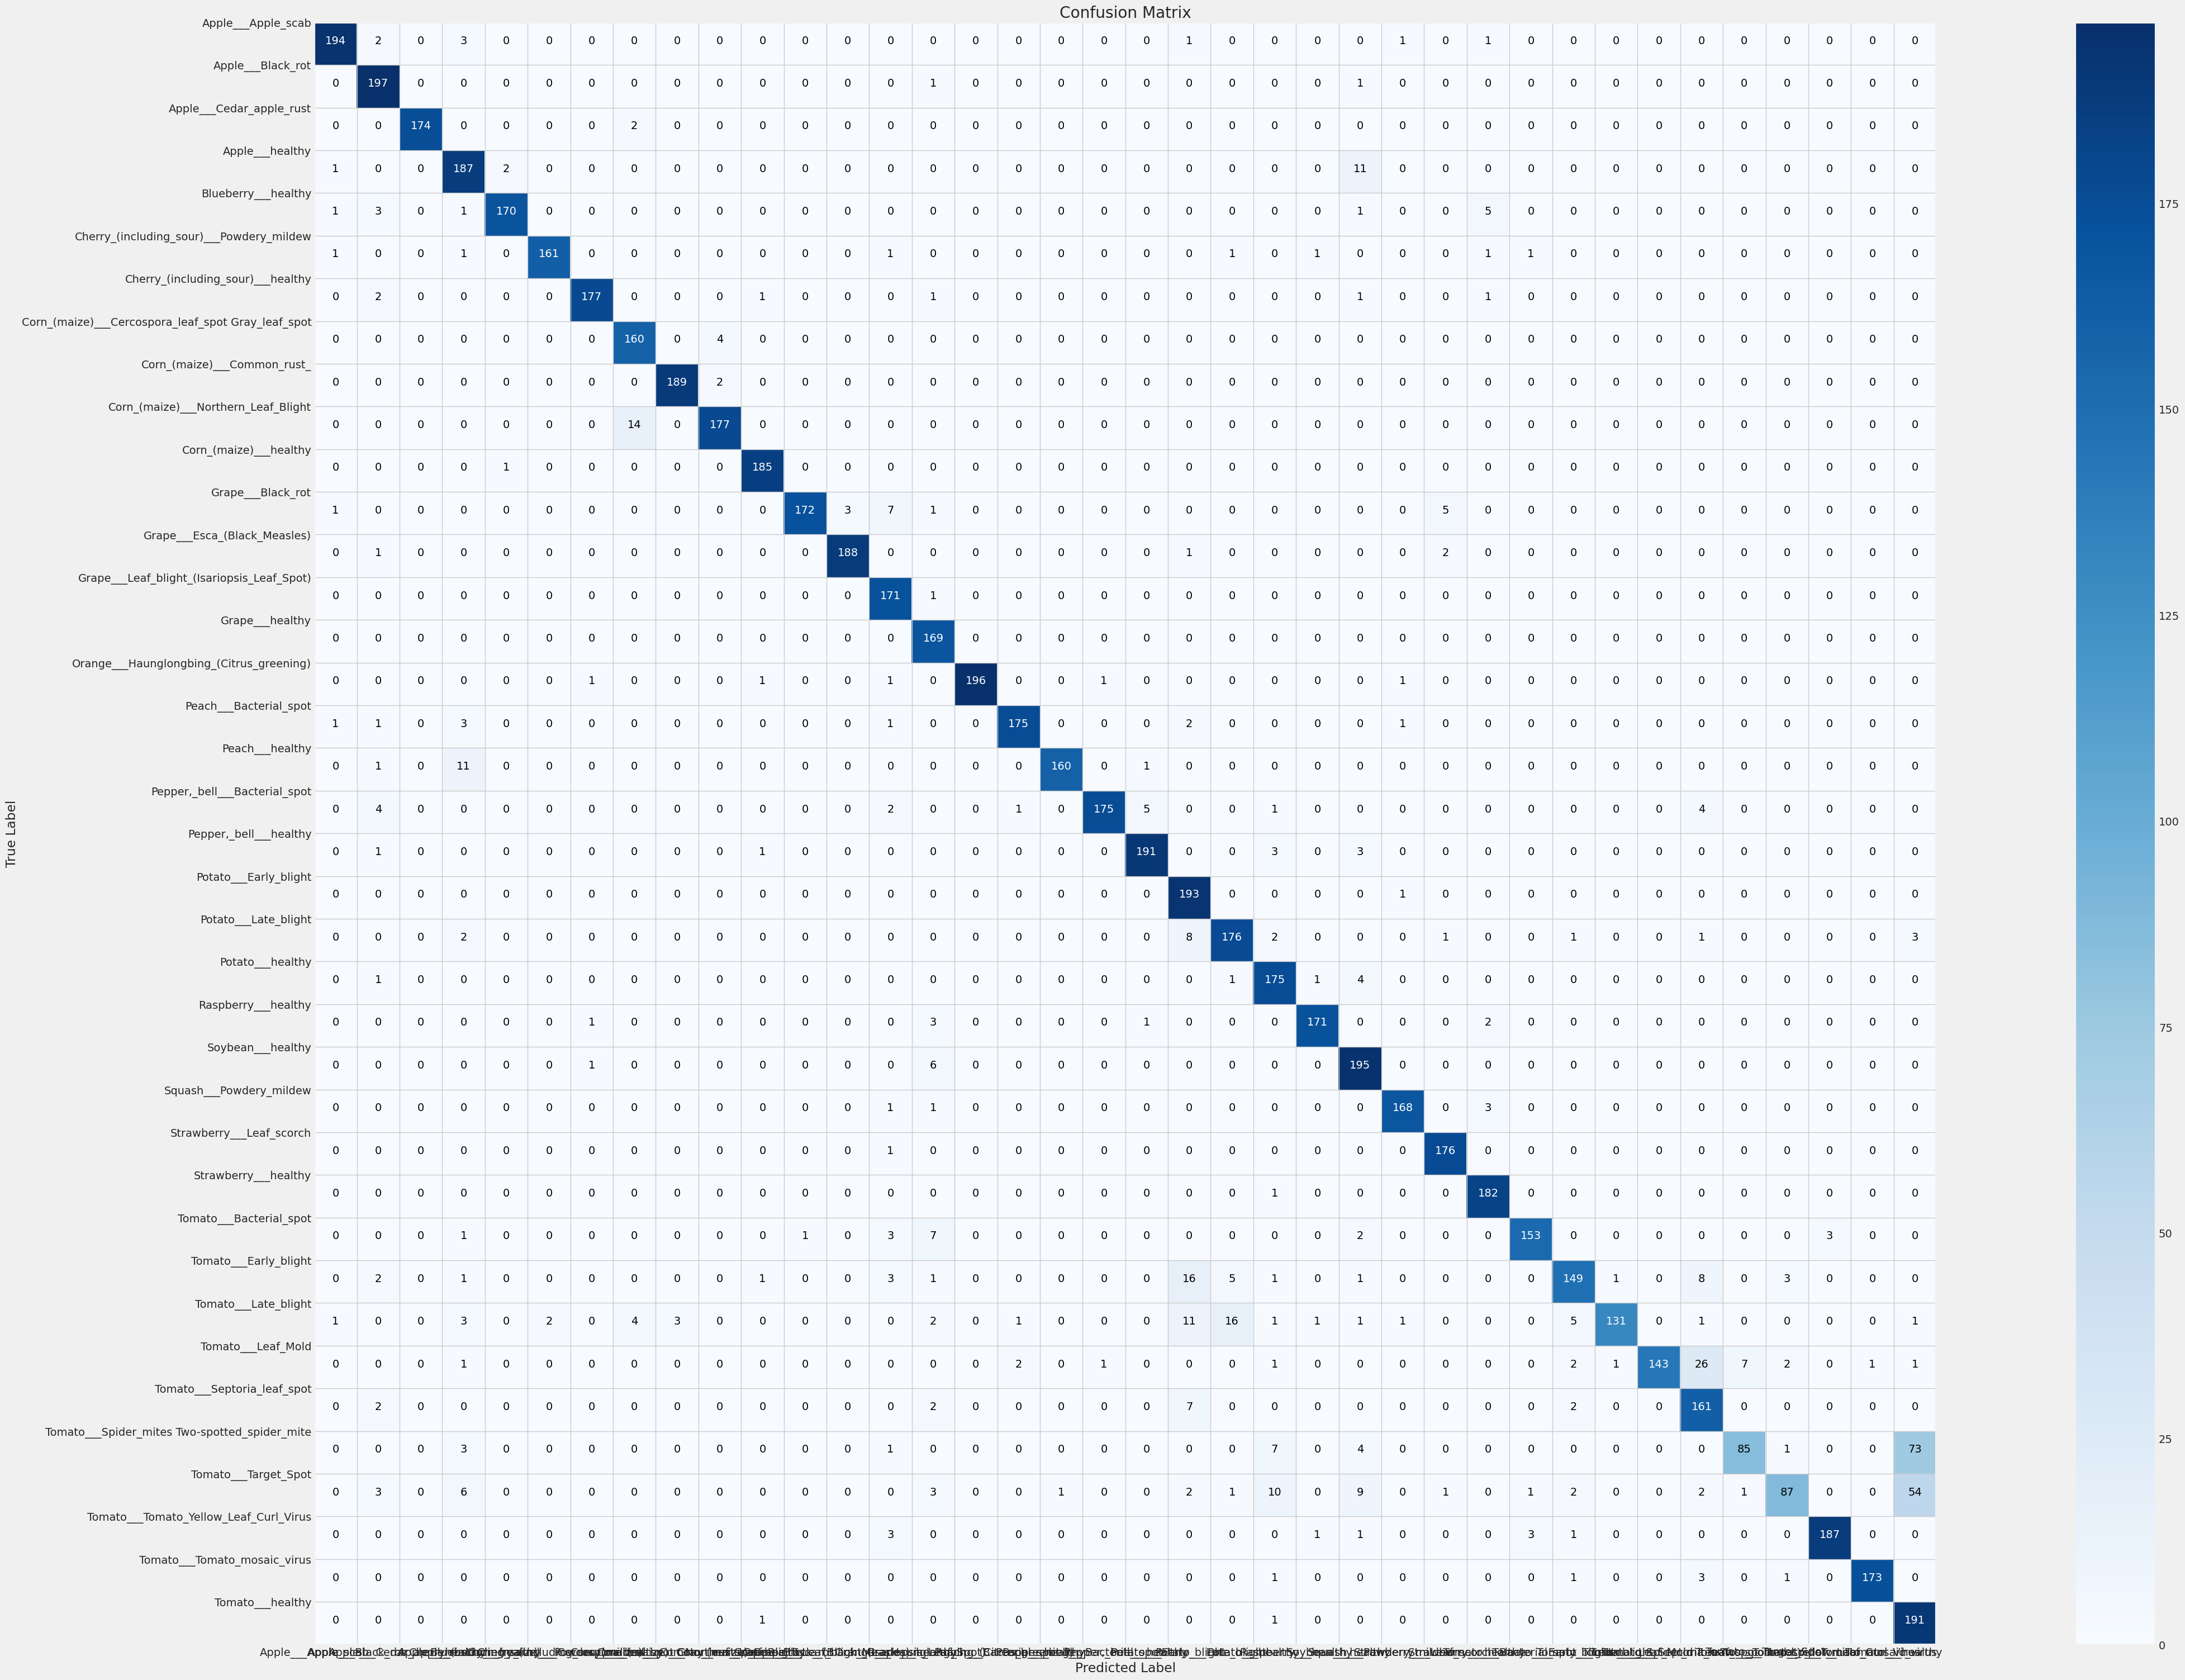

In [26]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (50, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step


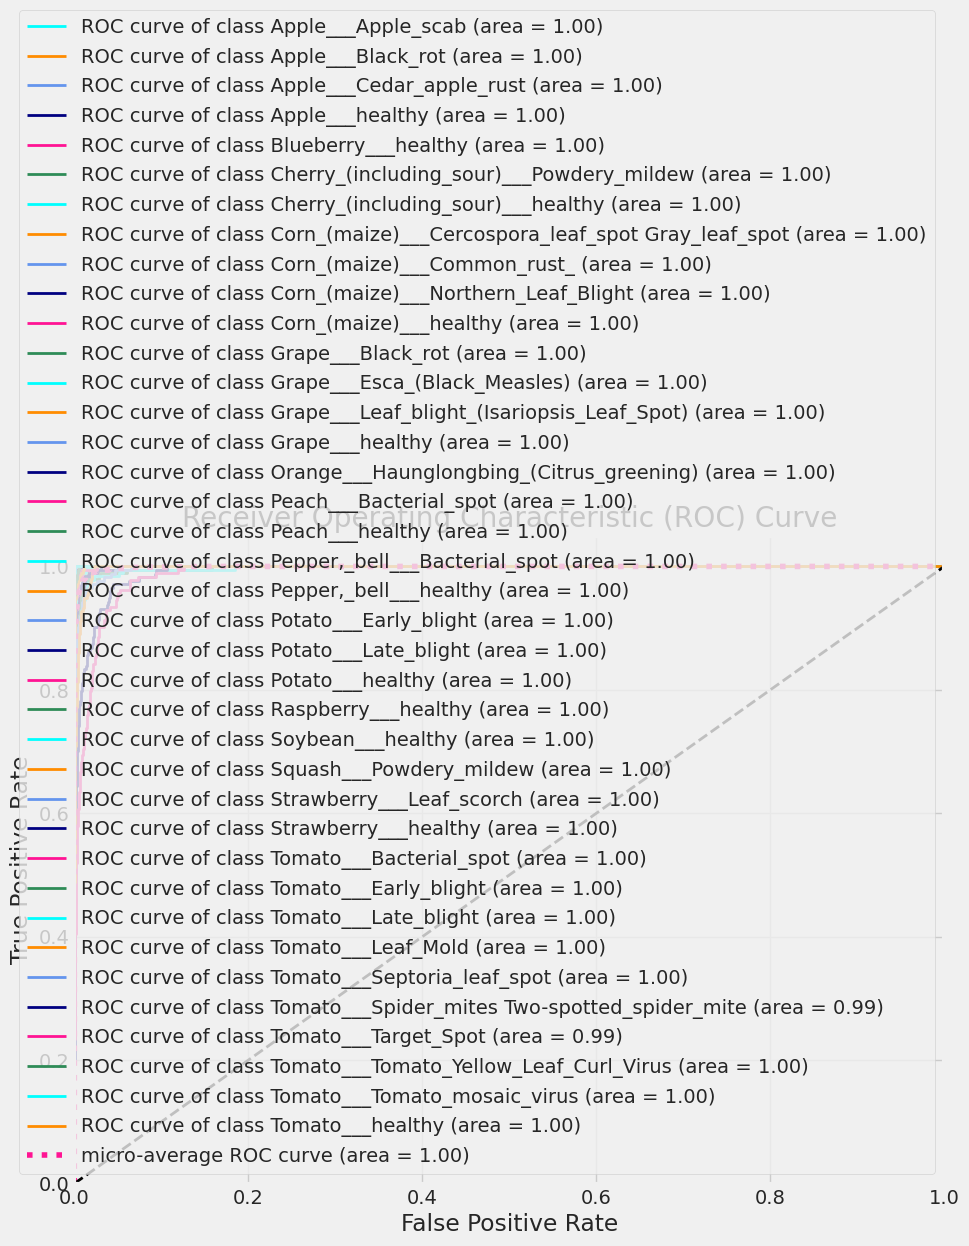

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Apple___Apple_scab: 1.00
AUC for class Apple___Black_rot: 1.00
AUC for class Apple___Cedar_apple_rust: 1.00
AUC for class Apple___healthy: 1.00
AUC for class Blueberry___healthy: 1.00
AUC for class Cherry_(including_sour)___Powdery_mildew: 1.00
AUC for class Cherry_(including_sour)___healthy: 1.00
AUC for class Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1.00
AUC for class Corn_(maize)___Common_rust_: 1.00
AUC for class Corn_(maize)___Northern_Leaf_Blight: 1.00
AUC for class Corn_(maize)___healthy: 1.00
AUC for class Grape___Black_rot: 1.00
AUC for class Grape___Esca_(Black_Measles): 1.00
AUC for class Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1.00
AUC for class Grape___healthy: 1.00
AUC for class Orange___Haunglongbing_(Citrus_greening): 1.00
AUC for class Peach___Bacterial_spot: 1.00
AUC for class Peach___healthy: 1.00
AUC for class Pepper,_bell___Bacterial_spot: 1.00
AUC for class Pepper,_bell___healthy: 1.00
AUC for class Potato___Early_blight: 1.00
AUC for 